In [43]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
#from keras import layers
from keras.layers import Dense, Dropout, MaxPool2D, Conv2D, Flatten
#from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import os
#print(os.listdir("Dataset"))


In [50]:
# load dataset
X = np.load("X.npy")
y = np.load("Y.npy") # targets are one-hot encoded

# make target not one-hot encoded
y_normal = []
for target in y:
    y_normal.append(np.argmax(target))
y_normal = np.array(y_normal)

In [52]:
print(y.shape)
print(X.shape)

# expand dimension of data to be able to use keras
if X.ndim == 3:
    X = np.expand_dims(X, 3)
print("added dimension to X:{}".format(X.shape))

(2062, 10)
(2062, 64, 64, 1)
added dimension to X:(2062, 64, 64, 1)


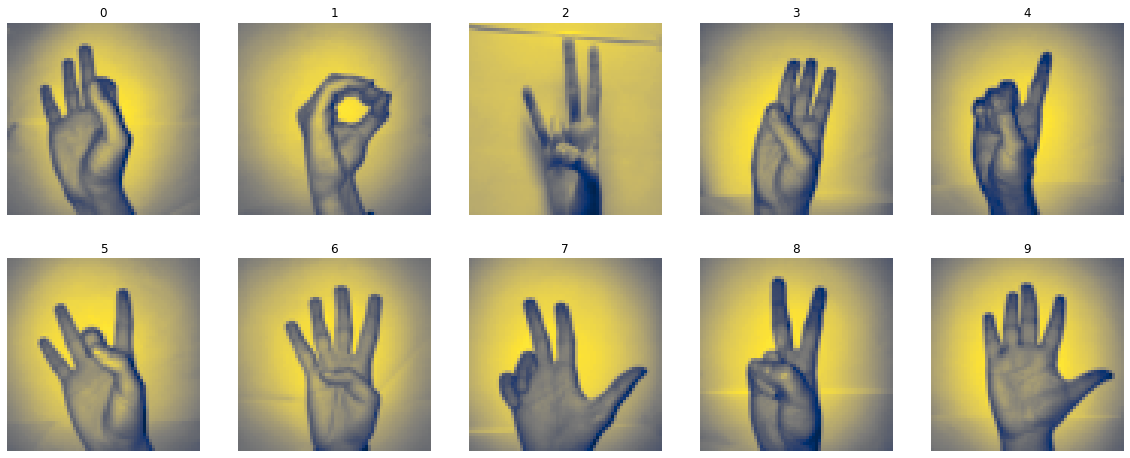

In [73]:
# example of data
def plot_examples(X):
    plt.figure(figsize=(20,6))

    for i,img in enumerate([0,205,411,617,823,1030,1237,1444,1650,1858]):
        plt.set_cmap('cividis')
        plt.subplot(2,5,i+1)
        plt.subplots_adjust(top = 2, bottom = 1)
        plt.imshow(X[img].reshape(64,64))
        plt.title(np.argmax(y[img]))
        plt.axis('off')

plot_examples(X)

In [54]:
# The images do not match the target values. We have to reorganize them.
# 9 is 0
# 0 is 1
# 7 is 2
# 6 is 3
# 1 is 4
# 8 is 5
# 4 is 6
# 3 is 7
# 2 is 8
# 5 is 9

# count number of samples for each number and print it in order
list_y = []
list_y = [np.where(i == 1)[0][0] for i in y]
count = pd.Series(list_y).value_counts()
print(count)



5    208
9    207
3    207
6    207
7    206
8    206
4    206
2    206
1    205
0    204
dtype: int64


In [55]:
# reorganize number ordering
X_organized = np.concatenate((X[204:409,:],
                              X[822:1028,:],
                              X[1649:1855,:],
                              X[1443:1649,:],
                              X[1236:1443,:],
                              X[1855:2062,:],
                              X[615:822,:],
                              X[409:615,:],
                              X[1028:1236,:],
                              X[0:204,:]),axis = 0)



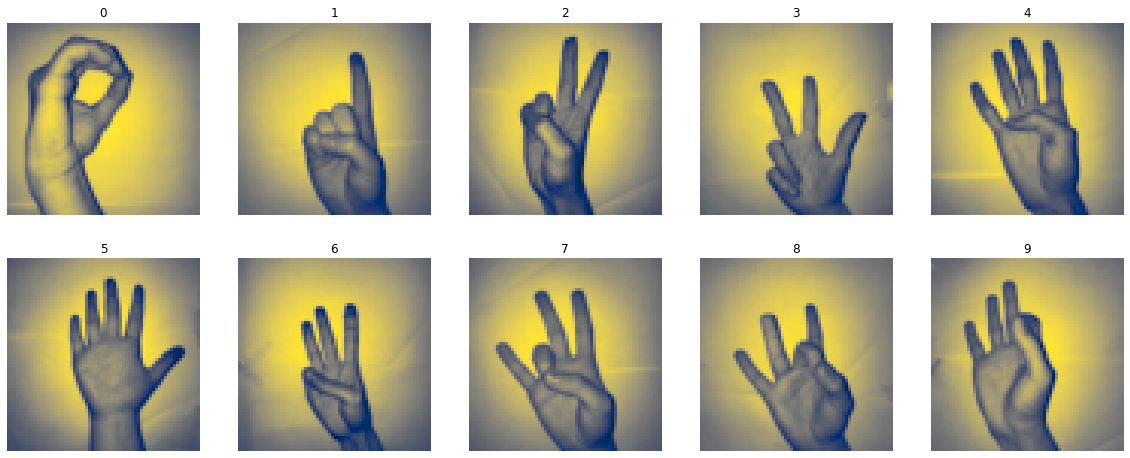

In [74]:
# we have them organized now
plot_examples(X_organized)

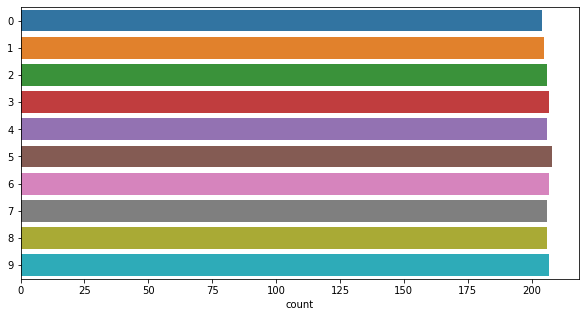

In [82]:
import seaborn as sns
plt.figure(figsize = (10,5))
#sns.countplot(np.array(list_y))
sns.countplot(y=np.array(list_y))
plt.show()

In [57]:
# split the data to training and testing set

x_train,x_test,y_train,y_test = train_test_split(X_organized,y,test_size = 0.2,random_state = 42)

print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (1649, 64, 64, 1)
x_test shape: (413, 64, 64, 1)
y_train shape: (1649, 10)
y_test shape: (413, 10)


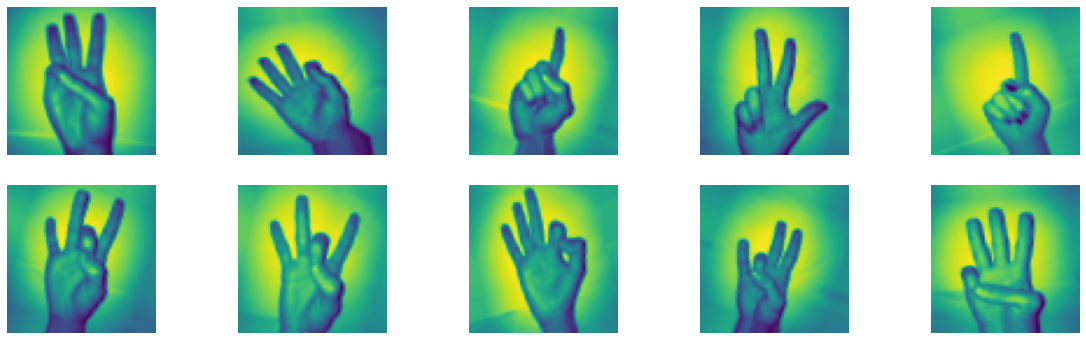

In [63]:
# DATA AUGMENTATION
def show_new_samples(new_images):
    plt.figure(figsize=(20,6))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image = new_images.next()
        plt.imshow(image[0].reshape(64,64))
        plt.axis('off')
    
    plt.show()

# ROTATION, ZOOM, and BRIGHTNESS
#datagen = ImageDataGenerator(rotation_range = 30, zoom_range = [0.9,1.2], brightness_range=[0.8,1.0])
# WITHOUT BRIGHTNESS
datagen = ImageDataGenerator(rotation_range = 20, zoom_range = [0.9,1.2])
new_images = datagen.flow(x_train,batch_size = 10)
show_new_samples(new_images)

# TODO HORIZONTAL SHIFT FOR REAL CASE USE


In [95]:
# MODEL

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (9,9),padding = 'Same', activation ='relu', input_shape = (64,64,1)))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(4,4), strides=(3,3)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128 , kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))

#model.add(Dense(256, activation = "relu", input_shape = (64,64,1)))
model.add(Dense(256, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation='softmax'))

# OPTIMIZER

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

datagen = ImageDataGenerator(rotation_range = 40, zoom_range = [0.9,1.5], brightness_range=[0.4,1.0])
datagen = ImageDataGenerator(rotation_range = 20, zoom_range = [0.9,1.2])
datagen.fit(x_train)

history = model.fit(datagen.flow(x_train,y_train, batch_size=250),epochs = 100, validation_data = (x_test,y_test))
#history = model.fit(x=x_train,y=y_train, batch_size=250, epochs = 100, validation_data = (x_test,y_test))

# EXPERIMENTS
# 1. 2x Dense 256
# 4. 3x Conv, 1x Dense

Epoch 1/100
7/7 [==============================] - 3s 396ms/step - loss: 2.3054 - accuracy: 0.0973 - val_loss: 2.3053 - val_accuracy: 0.0847
Epoch 2/100
7/7 [==============================] - 3s 369ms/step - loss: 2.3019 - accuracy: 0.0956 - val_loss: 2.3035 - val_accuracy: 0.1453
Epoch 3/100
7/7 [==============================] - 3s 362ms/step - loss: 2.3002 - accuracy: 0.1160 - val_loss: 2.3037 - val_accuracy: 0.0920
Epoch 4/100
7/7 [==============================] - 3s 384ms/step - loss: 2.2990 - accuracy: 0.1164 - val_loss: 2.2981 - val_accuracy: 0.0944
Epoch 5/100
7/7 [==============================] - 3s 374ms/step - loss: 2.2895 - accuracy: 0.1270 - val_loss: 2.2613 - val_accuracy: 0.1598
Epoch 6/100
7/7 [==============================] - 3s 384ms/step - loss: 2.2461 - accuracy: 0.1756 - val_loss: 2.0945 - val_accuracy: 0.2349
Epoch 7/100
7/7 [==============================] - 3s 364ms/step - loss: 2.0712 - accuracy: 0.2256 - val_loss: 1.7585 - val_accuracy: 0.3632
Epoch 8/100
7

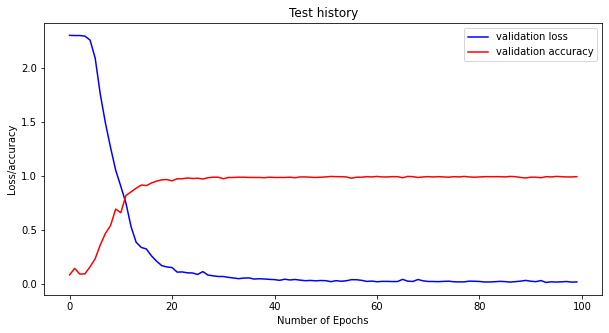

In [96]:
plt.figure(figsize = (10,5))
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['val_accuracy'], color='r', label="validation accuracy")
plt.title("Test history")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/accuracy")
plt.legend()
plt.show()

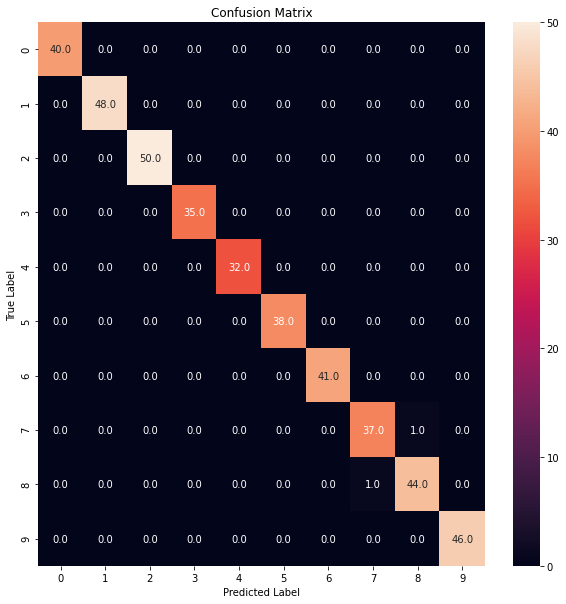

In [97]:
y_predict = model.predict(x_test)
y_predict_classes = np.argmax(y_predict,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_predict_classes) 
plt.figure(figsize = (10,10))
sns.color_palette("crest", as_cmap=True)
sns.heatmap(confusion_mtx, annot=True,fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

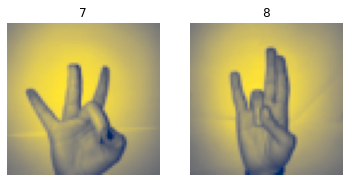

In [102]:
j = 0
for i in range(len(y_true)):
    if y_true[i] != y_predict_classes[i]:
        plt.set_cmap('cividis')
        plt.subplot(1,2,j+1)
        #plt.subplots_adjust(top = 2, bottom = 1)
        plt.imshow(x_test[i].reshape(64,64))
        plt.title(y_predict_classes[i])
        plt.axis('off')
        j+=1